# Урок 5. Случайный лес

In [ ]:
# Bootstrap & Bagging
X = [1, 2, 3, 4, 5]

X1 = [2, 4, 2, 4, 1] # tree_1.fit(X1, y)
X2 = [1, 3, 2, 3, 2] # tree_2.fit(X2, y)
X3 = [2, 4, 5, 5, 5] # tree_3.fit(X3, y)

tree_1.predict(test) # 1, 0, 0, 0
tree_2.predict(test) # 1, 1, 1, 0
tree_3.predict(test) # 0, 1, 0, 0
# 1, 1, 0, 0

## Домашнее задание

### 1. Задание:  
- Сформировать с помощью `sklearn.make_classification` датасет из 1000 объектов с **двумя** признаками.  
- Обучить случайный лес из 1, 3, 10, 50, 100 и 200 деревьев (за основу взять реализацию построения этого алгоритма из урока).  
- Визуализировать их разделяющие линии на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции `predict` на `tree_vote`).   
- Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from sklearn import datasets

import numpy as np

In [2]:
# сгенерируем данные, представляющие собой 1000 объектов с 2-мя признаками
X, y = make_classification(n_samples=1000,
                           n_features=2, n_informative=2, 
                           n_classes=2, n_redundant=0, 
                           n_clusters_per_class=2, flip_y=0.1, random_state=1)

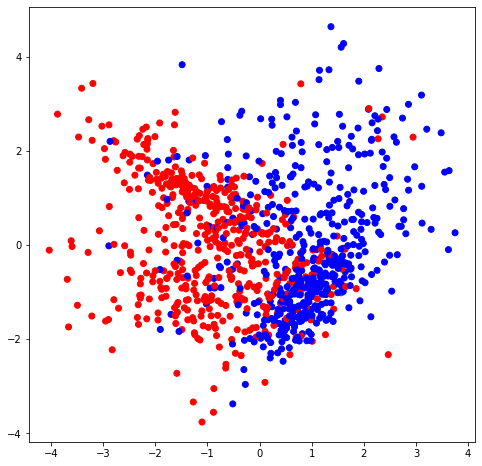

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], X)), list(map(lambda x: x[1], X)), 
              c=y, cmap=colors);

Реализуем генерацию $N$ бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.

In [4]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [5]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

Далее повторим реализацию построения дерева решений из предыдущего урока с некоторыми изменениями

In [6]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [7]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [8]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [9]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [10]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [11]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее min_leaf объекта
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [12]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Теперь добавим функцию формирования случайного леса.

In [13]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [14]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [15]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [16]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [17]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(X, y, test_size = 0.3, random_state = 1)

In [18]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

Теперь построим несколько случайных лесов с разным количеством деревьев в них.

In [19]:
# создадим функцию построения леса из N деревьев
forests = []
train_metrics = []
test_metrics = []

def grow_forest(n_trees):
    print(f'Случайный лес из {n_trees} деревьев')
    my_forest = random_forest(train_data, train_labels, n_trees)
    forests.append(my_forest)
    # Ответы для обучающей выборки
    train_answers = tree_vote(my_forest, train_data)
    # Ответы для тестовой выборки
    test_answers = tree_vote(my_forest, test_data)
    # Точность на обучающей выборке
    train_accuracy = accuracy_metric(train_labels, train_answers)
    train_metrics.append(train_accuracy)
    print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
    # Точность на тестовой выборке
    test_accuracy = accuracy_metric(test_labels, test_answers)
    test_metrics.append(test_accuracy)
    print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')
    return my_forest

In [20]:
%%time
#forest_dense_test = [1, 3, 10]
forest_dense = [1, 3, 10, 50, 100, 200]
for trees in forest_dense:
    grow_forest(trees)
    print('-'*100)
    print()

Случайный лес из 1 деревьев
Точность случайного леса из 1 деревьев на обучающей выборке: 90.429
Точность случайного леса из 1 деревьев на тестовой выборке: 68.667
----------------------------------------------------------------------------------------------------

Случайный лес из 3 деревьев
Точность случайного леса из 3 деревьев на обучающей выборке: 95.714
Точность случайного леса из 3 деревьев на тестовой выборке: 77.000
----------------------------------------------------------------------------------------------------

Случайный лес из 10 деревьев
Точность случайного леса из 10 деревьев на обучающей выборке: 99.000
Точность случайного леса из 10 деревьев на тестовой выборке: 78.333
----------------------------------------------------------------------------------------------------

Случайный лес из 50 деревьев
Точность случайного леса из 50 деревьев на обучающей выборке: 100.000
Точность случайного леса из 50 деревьев на тестовой выборке: 79.333
-----------------------------------

In [ ]:
#%whos

<Figure size 1008x504 with 0 Axes>

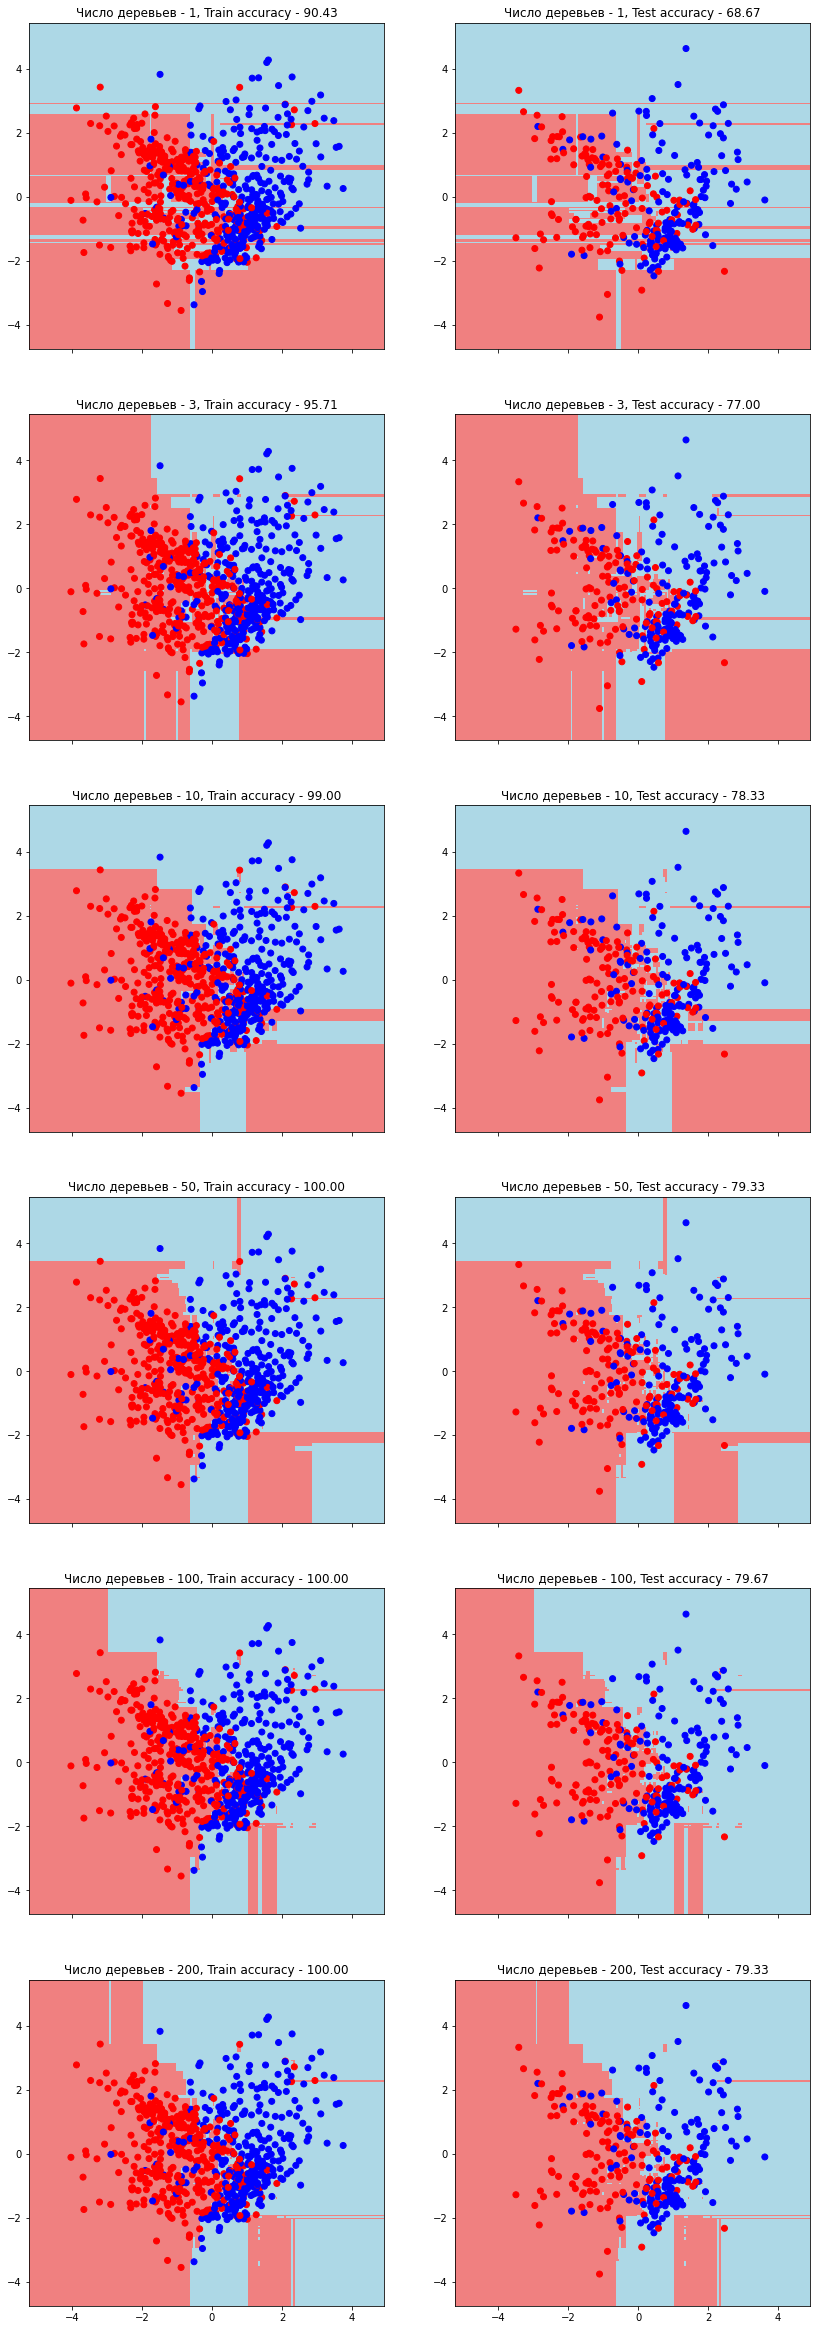

Wall time: 40 s


In [24]:
%%time
# Визуализируем дерево на графике
import warnings
warnings.filterwarnings("ignore")

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

n = len(forest_dense)
plt.figure(figsize = (14, 7))
figure, axes = plt.subplots(nrows=n, ncols=2, sharex=True, figsize=(14, 7 * n))
num = 0 # number of model

for model in forests:
    
    ax = axes[num, 0]
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(model, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    ax.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
    ax.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, cmap=colors)
    ax.set_title('Число деревьев - {}, Train accuracy - {:.2f}'.format( 
                                                forest_dense[num],
                                                train_metrics[num]));
    ax = axes[num, 1]
    ax.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
    ax.scatter(test_data[:, 0], test_data[:, 1], c=test_labels, cmap=colors)
    ax.set_title('Число деревьев - {}, Test accuracy - {:.2f}'.format( 
                                                forest_dense[num],
                                                test_metrics[num]));
    num += 1
plt.show();

__Вывод:__<br>
Чем больше деревьев в лесу тем сложнее гиперплоскость. При малом количестве деревьев (1-3) модель недообучена. При количестве деревьев от 10 до 50 модель получает хорошую точность. Дальнейший рост числа деревьев не дает значимого прироста точности. При этом модель не переобучается. Стоит отметить, что число деревьев должно быть соотнесено с количеством признаков. Чем больше признаков, тем гуще лес.

### $^*$2. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

## Дополнительные материалы

1. [Смещение и разброс](https://dyakonov.org/2018/04/25/%D1%81%D0%BC%D0%B5%D1%89%D0%B5%D0%BD%D0%B8%D0%B5-bias-%D0%B8-%D1%80%D0%B0%D0%B7%D0%B1%D1%80%D0%BE%D1%81-variance-%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8-%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82/)
2. [Бэггинг с точки зрения статистики](https://habr.com/ru/company/ods/blog/324402/#begging)
3. Андреас Мюллер, Сара Гвидо, Введение в машинное обучение с помощью Python. Руководство для специалистов по работе с данными (2016)

### $^{**}$3. Курсовой проект в этом курсе по желанию. На выбор две задачи:  
a) https://www.kaggle.com/c/tutors-expected-math-exam-results - предсказание среднего балла на ЕГЭ по математике, задача регрессии;  
b) https://www.kaggle.com/c/choose-tutors - предсказание вероятности того, что репетитор подходит студенту, задача бинарной классификации.  
При решении запрещены любые импорты, кроме следующих:

```
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
```